<h1><center>NLP Disaster Tweets Kaggle Mini-Project</center></h1>
<h2><center>Introduction to Deep Learning</center></h2>
<h3><center>DTSA-5511</center></h3>
<h3><center>University of Colorado Boulder</center></h3>
<h3><center>D. Stephen Haynes</center></h3>

# Natural Language Processing with Disaster Tweets
The goal of this project is to build a model that can accurately predict whether a tweet describes a real disaster. This will be a Natural Language Processing (NLP) task that labels input text as a disaster (1) or not a disaster (0).
- The details and datasets related to this competition are available here: https://www.kaggle.com/competitions/nlp-getting-started/overview

- The code below will perform the following:
    - Ingest the training and test datasets from the CSV files provided at the competition site above.
    - Evaluate the datasets for size, text dimensions, and label distribution
    - Split the training data into training and validation sets to evaluate labeling accuracy
    - Tokenize the training text using a GloVe method
    - Create a Recurrent Neural Network (RNN) and train the model on 80% of the training data
    - Measure the accuracy and loss of the RNN model
    - Adjust the model architecture and parameters and iterate through model evaluation to discover improvements
    - Apply the most accurate model to the test data and output the labeling results for submission to Kaggle
- The file will be submitted to the Kaggle competition for evaluation and ranking once the test data has been labeled.

## Recurrent Neural Network (RNN)
Recurrent Neural Networks (RNNs) are a class of neural networks that excel at processing data sequences. They are called recurrent because they perform the same task for every sequence element, with the output depending on the previous computations. Unlike feedforward neural networks, RNNs have a memory that captures information about what has been calculated so far, allowing them to have an internal state that captures information about the sequence they've processed to that point.
- The memory characteristic of RNNs is maintained by looping output back into inputs, making them well-suited for tasks where context is crucial, like the text data in this project.
Due to backpropagation, RNNs can suffer from vanishing gradients, where gradients shrink, and the model stops learning, especially during long sequences. To mitigate this issue, one variation of RNNs is Long Short-Term Memory (LSTM). LSTM is efficient at avoiding long-term dependency issues associated with generic RNNs. LSTM is especially well-suited to handle temporal dependencies like those in tweet texts.
- The RNN solutions used below will leverage the following layer types:
    - Embedding Layers: Used to convert text data into dense vectors of fixed size
    - LSTM Layers: Used to process sequence data and capture temporal dependencies
    - Dropout Layers: This prevents overfitting by randomly deactivating a portion of neurons during training, encouraging robust feature learning.
    - Dense Layers: These are used to interpret the features extracted by the RNN layers and drive predictions.

## The Dataset
- The data from the Kaggle Competition contains over 10,000 tweets. 7,613 of these tweets constitute the training portion of the data and include binary labeling. The test data contains 3,263 tweets without classification labels.
- The code below will load the data and output initial details of the datasets before evaluation.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from transformers import BertConfig, BertTokenizer, TFAutoModelForSequenceClassification, TFBertForSequenceClassification, create_optimizer
import keras_nlp


# Set the Keras backend to TensorFlow
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Enable GPU memory growth
def enable_gpu_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU Memory Growth Enabled")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

# Call the function to enable GPU memory growth immediately after TensorFlow import
enable_gpu_memory_growth()

# Verify library versions for compatibility
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

# Verify TensorFlow detects GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

GPU Memory Growth Enabled
TensorFlow version: 2.10.0
Keras version: 2.10.0
KerasNLP version: 0.4.0
Num GPUs Available: 1


In [2]:
# Import train and test datasets
train = pd.read_csv("C:/tweets/train.csv")
test = pd.read_csv("C:/tweets/test.csv")

# Display shape and memory usage
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


# Exploratory Data Analysis (EDA)
- To start, we'll quickly examine the data frames to ensure they are imported correctly and then review the size of each tweet.
- Next, we'll replace any null values, remove non-text items from the data, and standardize all text to lowercase.
- Finally, we'll visualize the number of words in each tweet and the distribution of labels in the training data.
- The training data is pre-labeled as tweets that describe a disaster (1) and those that do not (0).

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# Explore the tweet text sizing
train["length"] = train["text"].apply(lambda x : len(x))
test["length"] = test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train["length"].describe())
print()

print("Test Length Stat")
print(test["length"].describe())
print()

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64



In [6]:
# Handling missing values
train.fillna('', inplace=True)
test.fillna('', inplace=True)

def clean_text(text):
    """ Function to clean text data by removing URLs, HTML tags, and special characters """
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove special characters
    text = text.lower()  # Lower case the text
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)


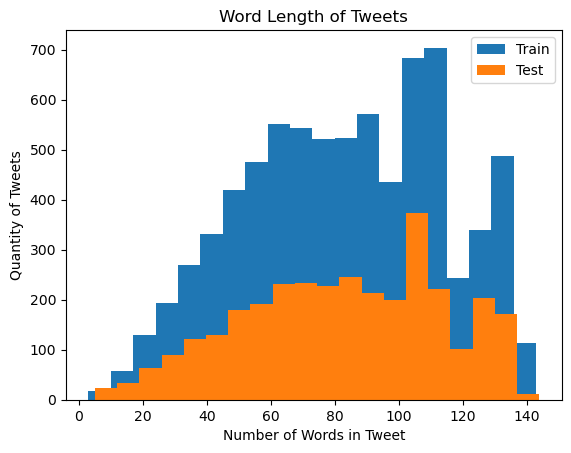

In [7]:
# Calculate length of cleaned text
train["clean_length"] = train["text"].apply(lambda x : len(x))
test["clean_length"] = test["text"].apply(lambda x : len(x))


# Display length of tweets for each dataset
plt.hist(train["clean_length"], bins=20, label="Train")
plt.hist(test["clean_length"], bins=20, label="Test")
plt.title("Word Length of Tweets")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Quantity of Tweets")
plt.legend()
plt.show()

The majority of tweets are between 50 and 110 words in length.

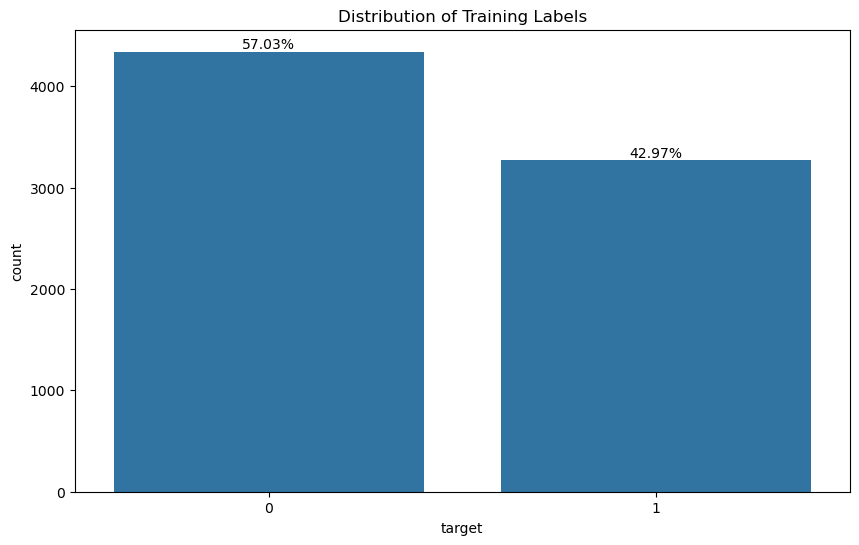

In [8]:
# Copy the submission dataframe to test_labels
train_labels = train

# Calculate percentage of each label
label_counts = train_labels['target'].value_counts()
total_count = len(train_labels)
label_percentages = (label_counts / total_count) * 100

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=train_labels)
plt.title("Distribution of Training Labels")


# Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    percentage = label_percentages[p.get_x() + p.get_width() / 2.0]
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.show()


## EDA Results
- Based on the label distribution above, we can see that the training images are nearly 60% non-disaster and 40% disaster-related.
- Each tweet is 100 words long on average, which is an appropriate length for capturing proper sentiment.

# Model Architecture
- Before we build our RNN model, we need to convert the text into numerical vectors for analysis. We'll choose the Global Vectors for Word Representation (GloVe) vectorization method for this project. GloVe is an unsupervised learning algorithm that leverages the overall statistics of word occurrences in a corpus to generate word embeddings. This model is built on the intuition that words appearing in similar contexts will likely have similar meanings. One key advantage of GloVe is that we can import pre-trained word vectors that encapsulate usage patterns of words across a vast text corpus like Wikipedia. This is especially useful for tasks like sentiment analysis, such as the disaster tweet classification needed for this project.
- Once we have converted our text into word vectors, we will build our RNN model. We will start with a small model using 2 LSTM layers. From there, we will split our training data into training and validation sets with an 80/20 ratio.
- From there, we will evaluate the accuracy and loss metrics and modify our model architecture to increase the accuracy.
- The architectural modifications that will be used are:
    - Additional layers
    - Bidirectional LSTM
    - Increased Dropout rates
    - Adjusted learning rates
    - Implement early stopping
- If the GloVe method does not provide sufficient accuracy results during training, we will also use Bidirectional Encoder Representations from Transformers (BERT). BERT leverages a deep transformer network to genreate text representations by considering a word's full context by looking at the words that come before and after it in a sentence. BERT can be advantageous compared to GloVe because it considers the full context of the text, which can be critical when distinguishing between figurative language and an actual disaster. Like GloVe, BERT also utilizes a text library pre-trained on diverse text data.
- Like before, we will apply similar architecture adjustments to the BERT model to improve accuracy.
- Once we have determined which model provides the best accuracy, we will apply it to the test data. The model will iterate through each test tweet and determine whether or not the text refers to an actual disaster. The tweet IDs will then be labeled with a 0 for non-disaster or 1 for disaster-related classification. This labeled test data will be displayed for evaluating label distribution and exported as a CSV file for submission to the Kaggle competition.

In [9]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])

# Pad sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Load GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    # Prepare embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100
embedding_matrix = load_glove_embeddings('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

# Create embedding layer
from keras.layers import Embedding
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)


# Model 1
- Initial model

In [10]:
# Define model architecture
model = Sequential([
    embedding_layer,
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1689900   
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,744,589
Trainable params: 54,689
Non-trainable params: 1,689,900
_________________________________________________________________


In [11]:
# Splitting the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_padded, train['target'], test_size=0.2, random_state=42)

In [12]:
# Train the model
history = model.fit(train_texts, train_labels, epochs=10, validation_data=(val_texts, val_labels))

Epoch 1/10
191/191 [==============================] - 4s 10ms/step - loss: 0.4935 - accuracy: 0.7739 - val_loss: 0.4427 - val_accuracy: 0.8201
Epoch 2/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4360 - accuracy: 0.8066 - val_loss: 0.4896 - val_accuracy: 0.7814
Epoch 3/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4175 - accuracy: 0.8186 - val_loss: 0.4160 - val_accuracy: 0.8234
Epoch 4/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3971 - accuracy: 0.8292 - val_loss: 0.4234 - val_accuracy: 0.8135
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3929 - accuracy: 0.8333 - val_loss: 0.4184 - val_accuracy: 0.8227
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3783 - accuracy: 0.8396 - val_loss: 0.4150 - val_accuracy: 0.8168
Epoch 7/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3647 - accuracy: 0.8478 - val_loss: 0.4325 - val_accuracy: 0.8122
Epoch

48/48 [==============================] - 0s 5ms/step - loss: 0.4668 - accuracy: 0.8076
Validation Accuracy: 80.76%


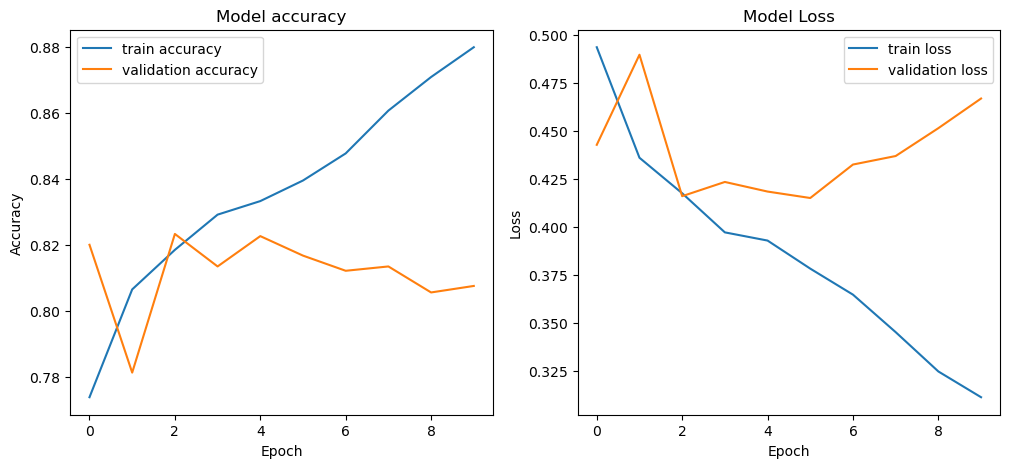

In [13]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_texts, val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 2
- Second model with additional Dropout Layer

In [14]:
# Create new model with additional Dropout layer
model2 = Sequential([
    embedding_layer,
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # Increased dropout rate
    LSTM(32, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1689900   
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          42240     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,744,589
Trainable params: 54,689
Non-t

In [15]:
# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [16]:
# Train the model with early stopping
history2 = model2.fit(train_texts, train_labels, epochs=10, validation_data=(val_texts, val_labels), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 5s 14ms/step - loss: 1.1325 - accuracy: 0.7663 - val_loss: 0.5815 - val_accuracy: 0.7965
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.5422 - accuracy: 0.7995 - val_loss: 0.4960 - val_accuracy: 0.8129
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.4966 - accuracy: 0.8057 - val_loss: 0.4933 - val_accuracy: 0.8162
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4886 - accuracy: 0.8005 - val_loss: 0.4956 - val_accuracy: 0.7965
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4756 - accuracy: 0.8048 - val_loss: 0.4551 - val_accuracy: 0.8089
Epoch 6/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4685 - accuracy: 0.8059 - val_loss: 0.4601 - val_accuracy: 0.8122
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4675 - accuracy: 0.8057 - val_loss: 0.4664 - val_accuracy: 0.8201
E

48/48 [==============================] - 0s 5ms/step - loss: 0.4551 - accuracy: 0.8089
Validation Accuracy: 80.89%


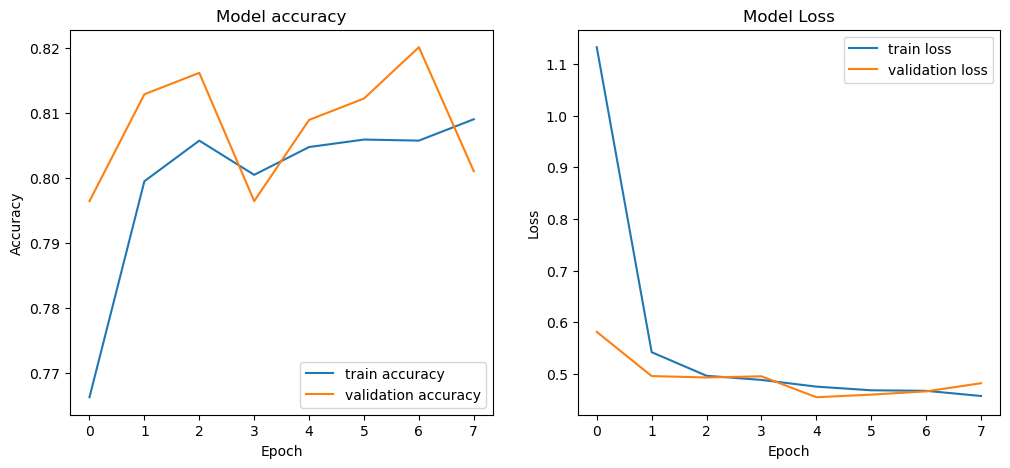

In [17]:
# Evaluate the model on the validation set
loss, accuracy = model2.evaluate(val_texts, val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='train accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 3
- Bidirectional LSTM and adjustable Learning Rate
- Model will be trained with Early Stopping

In [18]:
# Redefining the model to use a Bidirectional LSTM
model3 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Set adjustable learning rate
adam = Adam(learning_rate=0.0001)

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1689900   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        84480     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [19]:
# Train the model
history3 = model3.fit(train_texts, train_labels, epochs=10, validation_data=(val_texts, val_labels), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 7s 20ms/step - loss: 0.4885 - accuracy: 0.7714 - val_loss: 0.4312 - val_accuracy: 0.8135
Epoch 2/10
191/191 [==============================] - 3s 14ms/step - loss: 0.4300 - accuracy: 0.8125 - val_loss: 0.4336 - val_accuracy: 0.8122
Epoch 3/10
191/191 [==============================] - 3s 14ms/step - loss: 0.4109 - accuracy: 0.8233 - val_loss: 0.4430 - val_accuracy: 0.8122
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3984 - accuracy: 0.8310 - val_loss: 0.4126 - val_accuracy: 0.8267
Epoch 5/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3843 - accuracy: 0.8369 - val_loss: 0.4173 - val_accuracy: 0.8240
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3660 - accuracy: 0.8465 - val_loss: 0.5478 - val_accuracy: 0.7446
Epoch 7/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3511 - accuracy: 0.8552 - val_loss: 0.4194 - val_accuracy: 0.8253

48/48 [==============================] - 0s 6ms/step - loss: 0.4126 - accuracy: 0.8267
Validation Accuracy: 82.67%


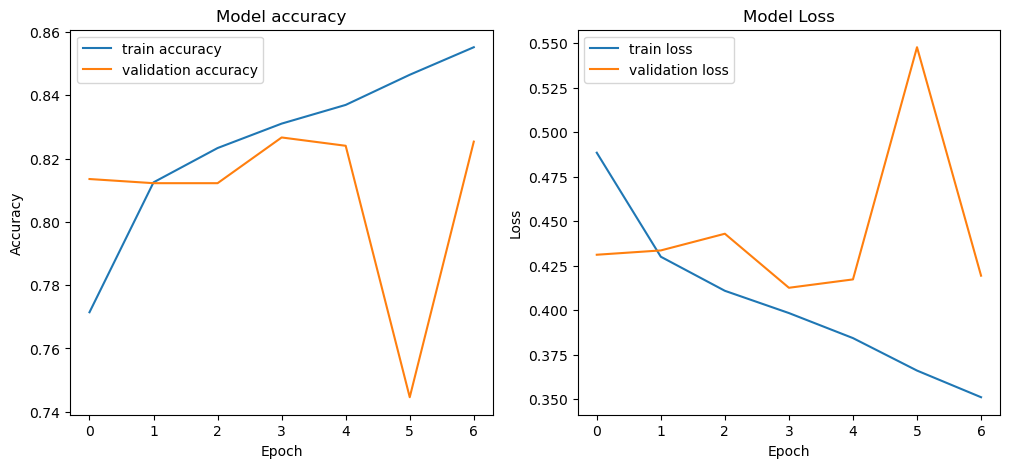

In [20]:
# Evaluate the model on the validation set
loss, accuracy = model3.evaluate(val_texts, val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='train accuracy')
plt.plot(history3.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 4
- Adding regularization
- Model training will be done with Early Stopping adjustment

In [21]:
model4 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    Dropout(0.5),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1689900   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [22]:
# Update EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history4 = model4.fit(train_texts, train_labels, epochs=10, validation_data=(val_texts, val_labels), callbacks=[early_stopping])

Epoch 1/10
191/191 [==============================] - 8s 21ms/step - loss: 1.1045 - accuracy: 0.6698 - val_loss: 0.9409 - val_accuracy: 0.7708
Epoch 2/10
191/191 [==============================] - 3s 14ms/step - loss: 0.8866 - accuracy: 0.7791 - val_loss: 0.8051 - val_accuracy: 0.8102
Epoch 3/10
191/191 [==============================] - 3s 14ms/step - loss: 0.7882 - accuracy: 0.7974 - val_loss: 0.7359 - val_accuracy: 0.8194
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.7284 - accuracy: 0.8057 - val_loss: 0.6925 - val_accuracy: 0.8234
Epoch 5/10
191/191 [==============================] - 3s 14ms/step - loss: 0.6864 - accuracy: 0.8094 - val_loss: 0.6571 - val_accuracy: 0.8260
Epoch 6/10
191/191 [==============================] - 3s 14ms/step - loss: 0.6514 - accuracy: 0.8135 - val_loss: 0.6309 - val_accuracy: 0.8253
Epoch 7/10
191/191 [==============================] - 3s 14ms/step - loss: 0.6231 - accuracy: 0.8158 - val_loss: 0.6087 - val_accuracy: 0.8247

48/48 [==============================] - 0s 7ms/step - loss: 0.5693 - accuracy: 0.8234
Validation Accuracy: 82.34%


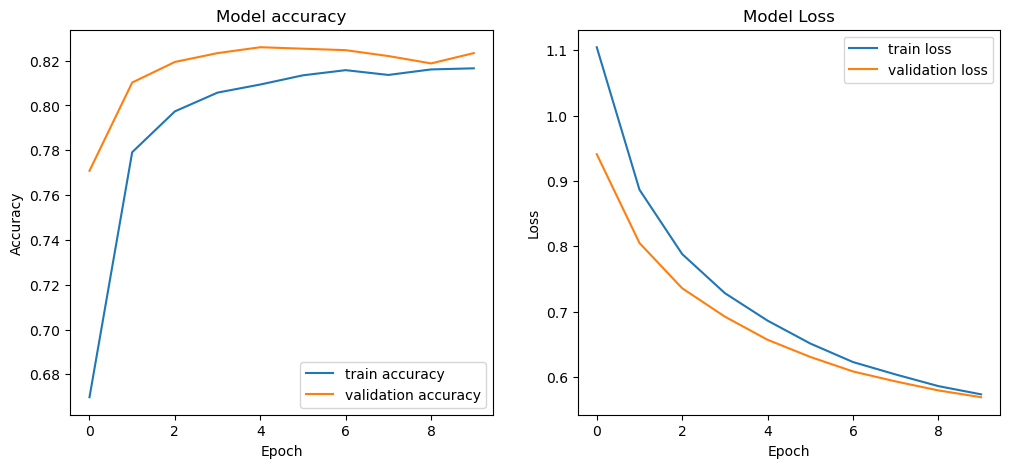

In [23]:
# Evaluate the model on the validation set
loss, accuracy = model4.evaluate(val_texts, val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='train accuracy')
plt.plot(history4.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 5
- First iteration of BERT Tokenization

In [24]:
# Split raw text data and labels
train_texts_raw, val_texts_raw, train_labels, val_labels = train_test_split(
    train['text'], train['target'], test_size=0.2, random_state=42)

In [25]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load BERT model
model5 = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

C:\Users\dstep\anaconda3\envs\py39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Function to encode sentences
def encode_sentences(tokenizer, sentences, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      # Sentence to encode.
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
            max_length=max_length,         # Pad & truncate all sentences.
            padding='max_length',          # Pad to max_length explicitly
            truncation=True,               # Explicitly truncate to max_length
            return_attention_mask=True,    # Construct attention masks.
            return_tensors='tf'            # Return tensorflow tensors.
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    
    return input_ids, attention_masks

# Assuming max_length of 128 tokens
train_input_ids, train_attention_masks = encode_sentences(tokenizer, train_texts_raw.tolist(), 128)
val_input_ids, val_attention_masks = encode_sentences(tokenizer, val_texts_raw.tolist(), 128)


In [27]:
# Setup training parameters
batch_size = 16
num_epochs = 3
num_train_steps = (len(train_labels) // batch_size) * num_epochs

# Create an optimizer with learning rate schedule
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)
model5.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model5.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_44 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Train the model
history5 = model5.fit(
    [train_input_ids, train_attention_masks], 
    train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    epochs=num_epochs,
    batch_size=batch_size
)

Epoch 1/3
381/381 [==============================] - 94s 209ms/step - loss: 0.4416 - accuracy: 0.8059 - val_loss: 0.3883 - val_accuracy: 0.8444
Epoch 2/3
381/381 [==============================] - 79s 207ms/step - loss: 0.3086 - accuracy: 0.8762 - val_loss: 0.3882 - val_accuracy: 0.8437
Epoch 3/3
381/381 [==============================] - 80s 211ms/step - loss: 0.2208 - accuracy: 0.9195 - val_loss: 0.4480 - val_accuracy: 0.8299


48/48 [==============================] - 5s 101ms/step - loss: 0.4480 - accuracy: 0.8299
Validation Accuracy: 82.99%


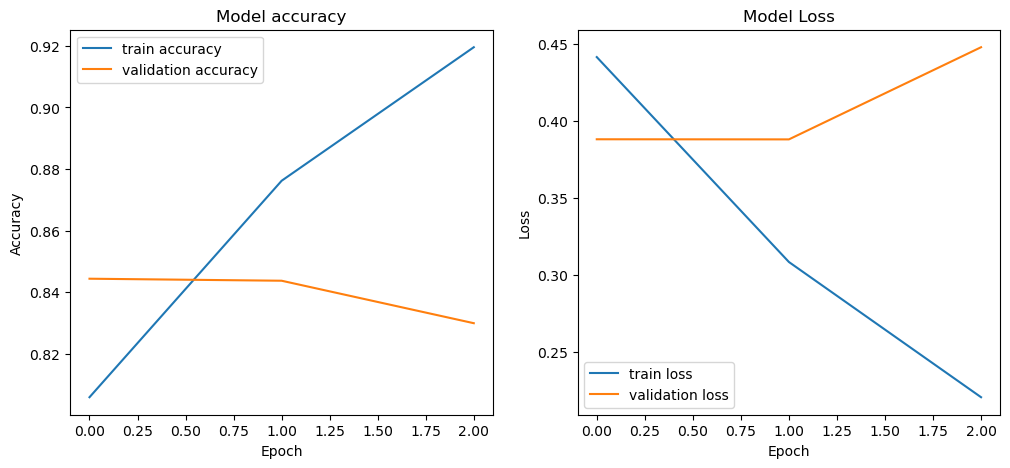

In [29]:
# Evaluate the model on the validation set
loss, accuracy = model5.evaluate([val_input_ids, val_attention_masks], val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='train accuracy')
plt.plot(history5.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 6
- Adding Early Stopping and Learning Rate Scheduler

In [30]:
# Load same BERT model from before
model6 = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Setup optimizer with a static initial learning rate
initial_learning_rate = 2e-5
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with the static learning rate
model6.compile(optimizer=optimizer, 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

model6.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_82 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    restore_best_weights=True
)

# Reduce learning rate when validation loss has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,   # Reduce learning rate by half
    patience=1, 
    min_lr=1e-6, 
    verbose=1     # Log when lr is reduced
)

# Train the model with callbacks
history6 = model6.fit(
    [train_input_ids, train_attention_masks], 
    train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, lr_scheduler]  # Include callbacks
)

Epoch 1/3
381/381 [==============================] - 87s 201ms/step - loss: 0.4372 - accuracy: 0.8087 - val_loss: 0.3985 - val_accuracy: 0.8372 - lr: 2.0000e-05
Epoch 2/3
381/381 [==============================] - 74s 194ms/step - loss: 0.3204 - accuracy: 0.8722 - val_loss: 0.3873 - val_accuracy: 0.8398 - lr: 2.0000e-05
Epoch 3/3
381/381 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9163
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
381/381 [==============================] - 75s 197ms/step - loss: 0.2261 - accuracy: 0.9163 - val_loss: 0.4646 - val_accuracy: 0.8332 - lr: 2.0000e-05


48/48 [==============================] - 5s 101ms/step - loss: 0.3873 - accuracy: 0.8398
Validation Accuracy: 83.98%


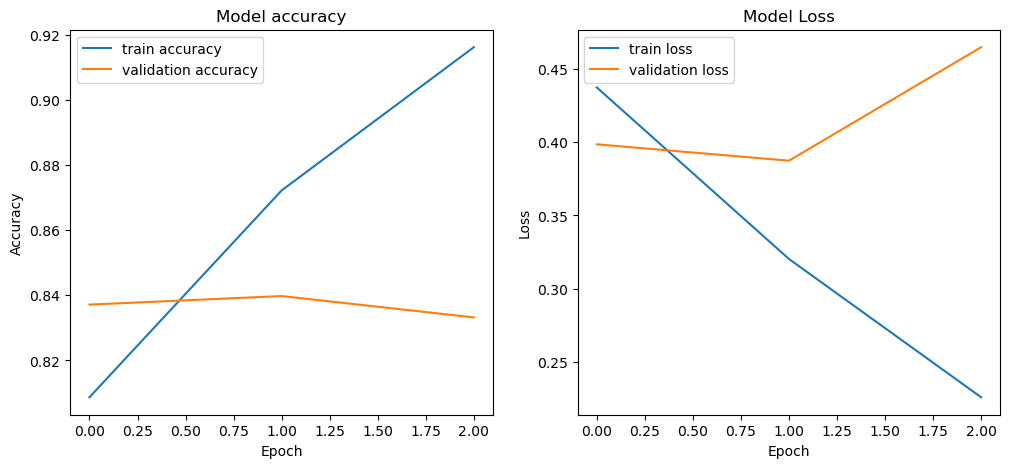

In [32]:
# Evaluate the model on the validation set
loss, accuracy = model6.evaluate([val_input_ids, val_attention_masks], val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='train accuracy')
plt.plot(history6.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='train loss')
plt.plot(history6.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model 7
- Adding Dropout

*** This model had to be run in smaller batches due to memory limits.

In [33]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the BERT configuration with increased dropout
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
config.hidden_dropout_prob = 0.5  # Increase dropout for hidden layers
config.attention_probs_dropout_prob = 0.5  # Increase dropout for attention layers

# Load BERT model with updated configuration
model7 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# Setup the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# Compile the model with specified loss function and metric
model7.compile(optimizer=optimizer, 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=['accuracy'])

model7.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_120 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Train the model with callbacks
history7 = model7.fit(
    [train_input_ids, train_attention_masks], 
    train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    epochs=num_epochs,
    batch_size=8,
    callbacks=[early_stopping, lr_scheduler]  # Include callbacks
)

Epoch 1/3
762/762 [==============================] - 116s 139ms/step - loss: 0.6826 - accuracy: 0.5563 - val_loss: 0.5333 - val_accuracy: 0.7656 - lr: 2.0000e-05
Epoch 2/3
762/762 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7209
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
762/762 [==============================] - 105s 138ms/step - loss: 0.5741 - accuracy: 0.7209 - val_loss: 0.5556 - val_accuracy: 0.7203 - lr: 2.0000e-05


48/48 [==============================] - 5s 101ms/step - loss: 0.4480 - accuracy: 0.8299
Validation Accuracy: 82.99%


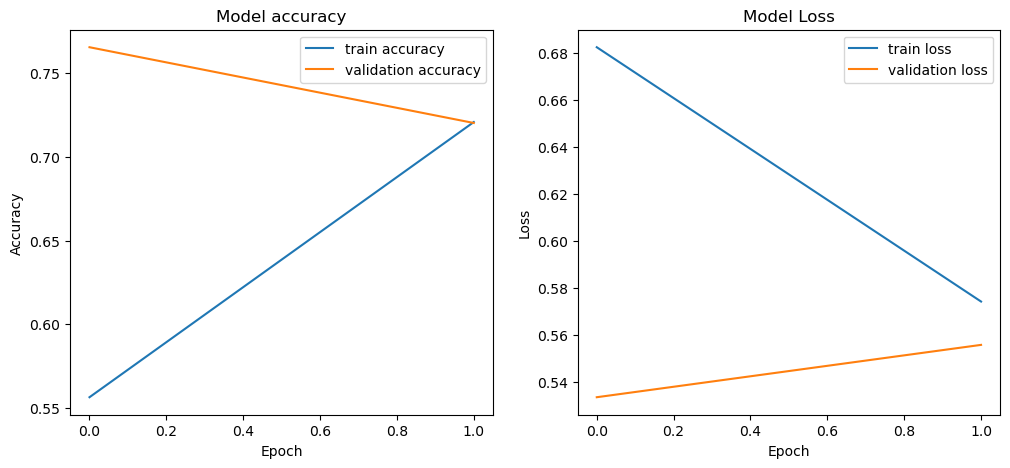

In [35]:
# Evaluate the model on the validation set
loss, accuracy = model5.evaluate([val_input_ids, val_attention_masks], val_labels)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'], label='train accuracy')
plt.plot(history7.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'], label='train loss')
plt.plot(history7.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

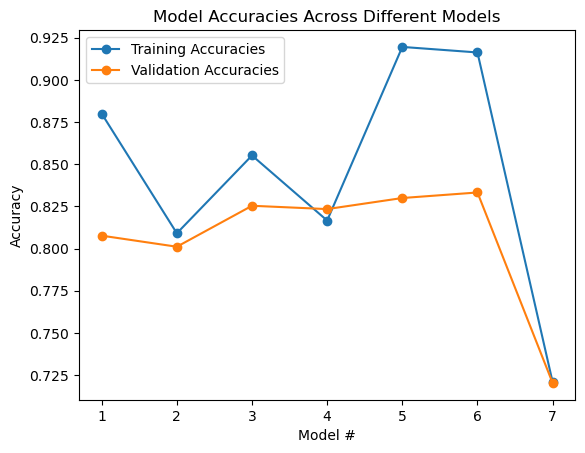

In [36]:
accuracies = [history.history["accuracy"][-1], history2.history["accuracy"][-1],
              history3.history["accuracy"][-1], history4.history["accuracy"][-1],
              history5.history["accuracy"][-1], history6.history["accuracy"][-1],
              history7.history["accuracy"][-1]]

val_accuracies = [history.history["val_accuracy"][-1], history2.history["val_accuracy"][-1],
                  history3.history["val_accuracy"][-1], history4.history["val_accuracy"][-1],
                  history5.history["val_accuracy"][-1], history6.history["val_accuracy"][-1],
                  history7.history["val_accuracy"][-1]]

# Indices for x-axis
indices = range(1, len(accuracies) + 1)

# Plotting
plt.plot(indices, accuracies, label="Training Accuracies", marker='o')
plt.plot(indices, val_accuracies, label="Validation Accuracies", marker='o')
plt.title("Model Accuracies Across Different Models")
plt.ylabel("Accuracy")
plt.xlabel("Model #")
plt.xticks(indices)  # Set x-ticks to be model numbers
plt.legend()
plt.show()

Based on the plot above, it looks like Model 5 gave us the best accuracy. We'll move forward with that version for our test data.

In [37]:
# Reoad the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [38]:
# Encode test data
test_input_ids, test_attention_masks = encode_sentences(tokenizer, test['text'].tolist(), max_length=128)

# Predict using the trained model
logits = model5.predict([test_input_ids, test_attention_masks])
probabilities = tf.nn.softmax(logits.logits, axis=-1)
predicted_labels = np.argmax(probabilities, axis=1)

# Attach predicted labels back to the test DataFrame
test['target'] = predicted_labels

# Prepare the submission DataFrame
submission = test[['id', 'target']]

# Display the first few rows to verify
print(submission.head())

# Save the DataFrame to a CSV file for submission
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 12s 100ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


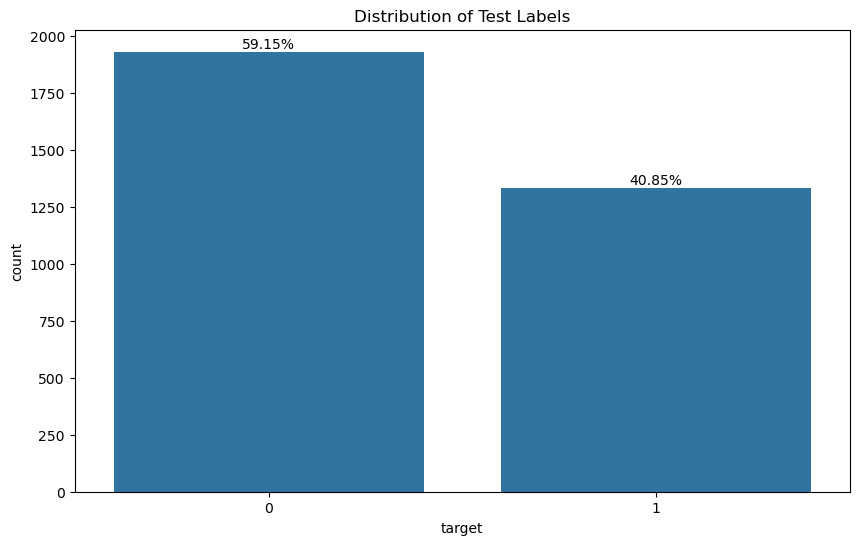

In [39]:
# Copy the submission dataframe to test_labels
test_labels = submission

# Calculate percentage of each label
label_counts = test_labels['target'].value_counts()
total_count = len(test_labels)
label_percentages = (label_counts / total_count) * 100

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=test_labels)
plt.title("Distribution of Test Labels")


# Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    percentage = label_percentages[p.get_x() + p.get_width() / 2.0]
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom')

plt.show()


# Results and Analysis
- With Model 5, we achieved 92% accuracy on the training data, yet we never made it higher than 83% accuracy with the validation set. The BERT word vectorization appeared to be far superior to GloVe, but I was unable to improve the initial BERT-based model with different architectures beyond the initial version.
- The distribution of labels remained relatively the same between training and test data sets with a 60/40 split of non-disaster to disaster classified tweets.
The final result of this code scored 0.8299 on the Kaggle Leaderboard, coming in 177th at the time of submission.

# Conclusion
Recurrent Neural Networks are powerful tools for processing sequential data. Whether reporting a disaster or discussing something benign, the meaning of a tweet can heavily depend on the sequence of words used. RNNs can capture the contextual relationships in sentences, which is crucial for this understanding.
- As I transitioned from the GloVe to BERT-based modeling, I was surprised to find how much more processing was required to achieve similar results. However, this does show the value that a more robust, pre-trained library can have on evaluating human languages.
- It is evident that there is a delicate balance of model tuning required to achieve the desired results. One's role in adjusting the number of layers or modifying other parameters can have a significant impact on how RNNs process data. Given more time and processing power, it would be interesting to explore more automated iteration through the various parameters to determine the best build for this particular project.

## References

[1] Natural Language Processing with Disaster Tweets:
- Addison Howard, devrishi, Phil Culliton, Yufeng Guo
- "Natural Language Processing with Disaster Tweets," Kaggle, 2019
- https://kaggle.com/competitions/nlp-getting-starteded}
}